In [1]:
import ee
import geemap
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import requests
from rasterio.warp import transform
import xarray as xr
import richdem as rd
import geopandas as gpd
# Initialize the Earth Engine module.
ee.Initialize()

In [2]:
#########################################################################
############################ USER INPUTS ################################
#########################################################################
# PATHS

# DOMAIN
# choose the modeling domain
domain = 'BRIS'

# path to temporary folder to store tif files from gee
TIFpath = domain + '_GEE_Downloads/'

# path to directory where you want your output .tif and .asc files
dataPath = '/nfs/attic/dfh/2020_NPRB/data/SMinputs/'+domain+'/'
#########################################################################

# Download DEM and LC data from GEE

In [3]:
# Download dem and veg data function Copernicus only
def get_topoveg(domain, OUTpath):
    
    #path to CSO domains
    domains_resp = requests.get("https://raw.githubusercontent.com/NPRB/02_preprocess_python/main/NPRB_domains.json")
    domains = domains_resp.json()

    # These are the min and max corners of your domain in Lat, Long
    minLat = domains[domain]['Bbox']['latmin']
    #// Input the minimum long, lower left corner
    minLong = domains[domain]['Bbox']['lonmin']
    #// Input the max lat, upper right corner
    maxLat = domains[domain]['Bbox']['latmax']
    #// Input the max Long, upper right corner
    maxLong = domains[domain]['Bbox']['lonmax']

    # The resolution for the NLCD and DEM outputs for the SnowModel domain in meters
    sm_resolution = int(domains[domain]['cellsize'])

    # Define the final output projection using EPSG codes
    epsg_code = domains[domain]['mod_proj']

    my_domain = ee.Geometry.Rectangle(**{'coords':[minLong,minLat,maxLong,maxLat],'proj': 'EPSG:4326','geodesic':True,});

    # Use the GMTED 2010 elevation data for the DEM
    GMTED = ee.Image('USGS/GMTED2010').select('be75');
    # GMTED = ee.Image('NASA/ASTER_GED/AG100_003');
    
    filename = os.path.join(OUTpath, domain+'_dem.tif')
    geemap.ee_export_image(GMTED, filename=filename, scale=sm_resolution, region=my_domain, crs = epsg_code);

    # Use the Copernicus land cover product for the veg type
    copernicus = ee.ImageCollection('COPERNICUS/Landcover/100m/Proba-V/Global')
    lc = copernicus.select('discrete_classification').toBands()
    
    sm_class = ee.Image(24) \
        .where(lc.eq(0), 18) \
        .where(lc.eq(20), 6) \
        .where(lc.eq(30), 12) \
        .where(lc.eq(40), 22) \
        .where(lc.eq(50), 21) \
        .where(lc.eq(60), 18) \
        .where(lc.eq(70), 20) \
        .where(lc.eq(80), 19) \
        .where(lc.eq(90), 9) \
        .where(lc.eq(100), 18) \
        .where(lc.eq(111), 1) \
        .where(lc.eq(112), 1) \
        .where(lc.eq(113), 2) \
        .where(lc.eq(114), 2) \
        .where(lc.eq(115), 3) \
        .where(lc.eq(116), 3) \
        .where(lc.eq(121), 4) \
        .where(lc.eq(122), 1) \
        .where(lc.eq(123), 2) \
        .where(lc.eq(124), 2) \
        .where(lc.eq(125), 3) \
        .where(lc.eq(126), 3) \
        .where(lc.eq(200), 24)
    
    
    # export lc image to tif
    filename = os.path.join(OUTpath, domain+'_veg.tif');
    geemap.ee_export_image(sm_class, filename=filename, scale=sm_resolution, region=my_domain, crs = epsg_code);

In [4]:
# execute GEE function
get_topoveg(domain, dataPath)

Generating URL ...
Please wait ...
Data downloaded to /nfs/attic/dfh/2020_NPRB/data/SMinputs/BRIS/BRIS_dem.tif
Generating URL ...
Please wait ...
Data downloaded to /nfs/attic/dfh/2020_NPRB/data/SMinputs/BRIS/BRIS_veg.tif


/nfs/attic/dfh/miniconda/envs/ee/lib/python3.9/site-packages/pyproj/crs/crs.py:292: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
/nfs/attic/dfh/miniconda/envs/ee/lib/python3.9/site-packages/pyproj/crs/crs.py:292: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


Text(0.5, 1.0, 'land cover')

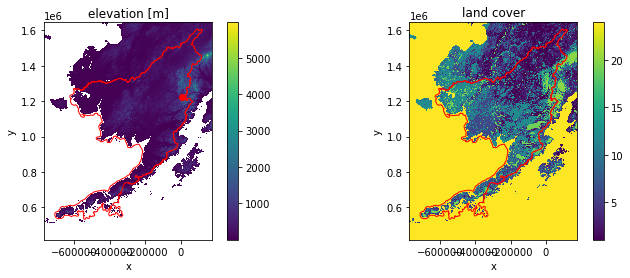

In [21]:
# visualize tif with shapefile
# this allows you to ensure that the bounding box covers the full domain
DEMfile = dataPath+domain+'_dem.tif'
dem = xr.open_rasterio(DEMfile)
LCfile = dataPath+domain+'_veg.tif'
lc = xr.open_rasterio(LCfile)
shp = gpd.read_file('/nfs/attic/dfh/2020_NPRB/data/gis/'+domain+'/'+domain+'.json')
shpproj = shp.to_crs(dem.crs)
#plot
fig,(ax,ax2) = plt.subplots(1,2,figsize=[12,4])
#dem.plot(ax=ax)
dem.where(dem>0).plot(ax=ax)
shpproj.plot(ax=ax,facecolor='None',edgecolor='r')
ax.set_title('elevation [m]')
# gdfproj=gdf.to_crs(dem.crs)
# gdfproj.loc[gdfproj.code=='1266_AK_SNTL'].plot(ax=ax,c='r')
lc.plot(ax=ax2)
shpproj.plot(ax=ax2,facecolor='None',edgecolor='r')
ax2.set_title('land cover')

In [4]:
#determine landcover type at snotel sites
#start calibration date    
st_dt = '2011-10-01'
#end calibration date
ed_dt = '2018-09-30'
gdf = gpd.read_file('/nfs/attic/dfh/2020_NPRB/data/snotel/'+domain+'/Station_sites_SWEDmeters_'+domain+'_'+st_dt+'_'+ed_dt+'.geojson')
gdf

,code,longitude,latitude,name,elevation_m,easting,northing,geometry
0,1062_AK_SNTL,-151.315002,59.859718,Anchor River Divide,503.83441162109375,149850.411805,1.099633e+06,POINT (149850.412 1099632.828)
1,987_AK_SNTL,-151.847687,59.350651,Port Graham,91.44000244140625,121977.382195,1.041656e+06,POINT (121977.382 1041656.002)
2,1266_AK_SNTL,-153.917725,60.982430,Telaquana Lake,388.6199951171875,4437.498702,1.222173e+06,POINT (4437.499 1222172.720)


In [5]:
lc

<xarray.DataArray (band: 1, y: 1228, x: 949)>
[1165372 values with dtype=uint8]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 1.644e+06 1.644e+06 1.642e+06 ... 4.185e+05 4.175e+05
  * x        (x) float64 -7.705e+05 -7.695e+05 ... 1.765e+05 1.775e+05
Attributes:
    transform:               (1000.0, 0.0, -771000.0, 0.0, -1000.0, 1645000.0)
    crs:                     +init=epsg:3338
    res:                     (1000.0, 1000.0)
    is_tiled:                1
    nodatavals:              (0.0,)
    scales:                  (1.0,)
    offsets:                 (0.0,)
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1

In [8]:
lc.sel(x=gdf.geometry.x[2],y=gdf.geometry.y[2],method='nearest').values

array([3], dtype=uint8)

## DEM with LC
### Edit landcover and dem to prevent negative discharge values

1. set the elevation of any dem pixels corresponding to ocean landcover, to 0

2. Set and landcover pixels that correspond to zero elevation, to ocean

3. fill in any depressions

In [3]:
# 2-8-24 add
def DEM_LC2SM_fill(DEM_tiffpath,LC_tiffpath,OUTpath,fill=True):
    # open dem .tif
    dem = xr.open_rasterio(DEM_tiffpath)
    # open lc .tif
    lc = xr.open_rasterio(LC_tiffpath)
    #change all cells in the dem that correspond to the ocean lc type to 0 elevation
    dems=dem.where(lc!=24,-9999)
    #change all cells in the lc that correspond to 0 elevation, to 24
    #lcs=lc.where(dems!=0,24)
    #ascii header 
    head = "ncols\t"+str(dem.shape[2])+"\n" \
        "nrows\t"+str(dem.shape[1])+"\n" \
        "xllcorner\t"+str(int(min(dem.x.values)-dem.res[0]/2))+"\n" \
        "yllcorner\t"+str(int(min(dem.y.values)-dem.res[0]/2))+"\n" \
        "cellsize\t"+str(int(dem.res[0]))+"\n" \
        "NODATA_value\t-9999" 

    if fill == True:
        print('generating filled dem')
        #make richdem array
        rda = rd.rdarray(np.squeeze(dems.values), no_data=-9999)
        #fill depressions in DEM to level of lowest outlet or spill-point
        dem_filled = rd.BreachDepressions(rda, in_place=False)
        #save filled dem
        np.savetxt(OUTpath+domain+'_dem.asc', dem_filled, fmt='%d', header = head,comments='')
    elif fill == False:
        print('dem not filled')
        #save dem
        np.savetxt(OUTpath+domain+'_demHF.asc', np.squeeze(dems.values), fmt='%d', header = head,comments='') 

    #save lc
    np.savetxt(OUTpath+domain+'_vegHF.asc', np.squeeze(lc.values), fmt='%d', header = head,comments='')
    

In [4]:
# generate topoveg SM input files
DEM_tiffpath = dataPath+domain+'_dem.tif'
LC_tiffpath = dataPath+domain+'_veg.tif'
DEM_LC2SM_fill(DEM_tiffpath,LC_tiffpath,dataPath)

generating filled dem
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


In [3]:
def DEM_LC2SM_fill(DEM_tiffpath,LC_tiffpath,OUTpath,fill=True):
    # open dem .tif
    dem = xr.open_rasterio(DEM_tiffpath)
    # open lc .tif
    lc = xr.open_rasterio(LC_tiffpath)
    #change all cells in the dem that correspond to the ocean lc type to 0 elevation
    dems=dem.where(lc!=24,0)
    # #change all cells in the lc that correspond to 0 elevation, to 24
    # lcs=lc.where(dems!=0,24)
    #ascii header 
    head = "ncols\t"+str(dem.shape[2])+"\n" \
        "nrows\t"+str(dem.shape[1])+"\n" \
        "xllcorner\t"+str(int(min(dem.x.values)-dem.res[0]/2))+"\n" \
        "yllcorner\t"+str(int(min(dem.y.values)-dem.res[0]/2))+"\n" \
        "cellsize\t"+str(int(dem.res[0]))+"\n" \
        "NODATA_value\t-9999" 

    if fill == True:
        print('generating filled dem')
        #make richdem array
        rda = rd.rdarray(np.squeeze(dems.values), no_data=0)
        #fill depressions in DEM to level of lowest outlet or spill-point
        dem_filled = rd.BreachDepressions(rda, in_place=False)
        #save filled dem
        np.savetxt(OUTpath+domain+'_dem.asc', dem_filled, fmt='%d', header = head,comments='')
    elif fill == False:
        print('dem not filled')
        #save dem
        np.savetxt(OUTpath+domain+'_dem.asc', np.squeeze(dems.values), fmt='%d', header = head,comments='') 

    #save lc
    np.savetxt(OUTpath+domain+'_veg.asc', np.squeeze(lc.values), fmt='%d', header = head,comments='')
    

In [7]:
def DEM_LC2SM_fill(DEM_tiffpath,LC_tiffpath,OUTpath,fill=True):
    # open dem .tif
    dem = xr.open_rasterio(DEM_tiffpath)
    # open lc .tif
    lc = xr.open_rasterio(LC_tiffpath)
    #change all cells in the dem that correspond to the ocean lc type to 0 elevation
    dems=dem.where(lc!=24,0)
    #change all cells in the lc that correspond to 0 elevation, to 24
    lcs=lc.where(dems!=0,24)
    #ascii header 
    head = "ncols\t"+str(dem.shape[2])+"\n" \
        "nrows\t"+str(dem.shape[1])+"\n" \
        "xllcorner\t"+str(int(min(dem.x.values)-dem.res[0]/2))+"\n" \
        "yllcorner\t"+str(int(min(dem.y.values)-dem.res[0]/2))+"\n" \
        "cellsize\t"+str(int(dem.res[0]))+"\n" \
        "NODATA_value\t-9999" 

    if fill == True:
        print('generating filled dem')
        #make richdem array
        rda = rd.rdarray(np.squeeze(dems.values), no_data=0)
        #fill depressions in DEM to level of lowest outlet or spill-point
        dem_filled = rd.BreachDepressions(rda, in_place=False)
        #save filled dem
        np.savetxt(OUTpath+domain+'_dem.asc', dem_filled, fmt='%d', header = head,comments='')
    elif fill == False:
        print('dem not filled')
        #save dem
        np.savetxt(OUTpath+domain+'_dem.asc', np.squeeze(dems.values), fmt='%d', header = head,comments='') 

    #save lc
    np.savetxt(OUTpath+domain+'_veg.asc', np.squeeze(lcs.values), fmt='%d', header = head,comments='')
    

# Lat long grids

In [8]:
def LTLN2SM(INfile,OUTpath):
    da = xr.open_rasterio(INfile)

    # Compute the lon/lat coordinates with rasterio.warp.transform
    ny, nx = len(da.y), len(da.x)
    x, y = np.meshgrid(da.x, da.y)

    # Rasterio works with 1D arrays
    lon, lat = transform(da.crs, {'init': 'EPSG:4326'},
                         x.flatten(), y.flatten())
    lon = np.asarray(lon).reshape((ny, nx))
    lat = np.asarray(lat).reshape((ny, nx))

    #ascii header 
    head = "ncols\t"+str(da.shape[2])+"\n" \
    "nrows\t"+str(da.shape[1])+"\n" \
    "xllcorner\t"+str(int(min(da.x.values)-da.res[0]/2))+"\n" \
    "yllcorner\t"+str(int(min(da.y.values)-da.res[0]/2))+"\n" \
    "cellsize\t"+str(int(da.res[0]))+"\n" \
    "NODATA_value\t-9999"
    np.savetxt(OUTpath+domain+'_grid_lat.asc', lat, fmt='%2.5f', header = head,comments='')
    np.savetxt(OUTpath+domain+'_grid_lon.asc', lon, fmt='%4.5f', header = head,comments='')
    
    inF = OUTpath+domain+'_grid_lat.asc'
    outF = OUTpath+domain+'_grid_lat.tif'
    !gdal_translate -of "GTiff" $inF $outF

    inF = OUTpath+domain+'_grid_lon.asc'
    outF = OUTpath+domain+'_grid_lon.tif'
    !gdal_translate -of "GTiff" $inF $outF

# Execute functions - 1 domain

In [9]:
# # execute GEE function
# get_topoveg(domain, dataPath)

# generate topoveg SM input files
DEM_tiffpath = dataPath+domain+'_dem.tif'
LC_tiffpath = dataPath+domain+'_veg.tif'
DEM_LC2SM_fill(DEM_tiffpath,LC_tiffpath,dataPath)

#generate lat lon grids
LTLN2SM(DEM_tiffpath,dataPath)

generating filled dem
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Input file size is 949, 1228
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 949, 1228
0...10...20...30...40...50...60...70...80...90...100 - done.


In [9]:
# # AK domains
# domain_list = ['JUNE','KLAW','SITK','TAKU']
# # domain_list = ['BEAU','BRIS','CHUK','JUNE','KLAW','SITK','TAKU','YUKO']

# for domain in domain_list:
#     print(domain)
#     # path to directory where you want your output .tif and .asc files
#     dataPath = '/nfs/attic/dfh/2020_NPRB/data/SMinputs/'+domain+'/'

#     # execute GEE function
#     get_topoveg(domain, dataPath)
    
#     # generate topoveg SM input files
#     DEM_tiffpath = dataPath+domain+'_dem.tif'
#     LC_tiffpath = dataPath+domain+'_veg.tif'
#     DEM_LC2SM_fill(DEM_tiffpath,LC_tiffpath,dataPath)
    
#     #generate lat lon grids
#     LTLN2SM(DEM_tiffpath,dataPath)

In [5]:
# # landcover data 
# def LC2SM(INfile,OUTpath):
#     da = xr.open_rasterio(INfile)
#     data = np.squeeze(da.values)

#     #ascii header 
#     head = "ncols\t"+str(da.shape[2])+"\n" \
#     "nrows\t"+str(da.shape[1])+"\n" \
#     "xllcorner\t"+str(int(min(da.x.values)-da.res[0]/2))+"\n" \
#     "yllcorner\t"+str(int(min(da.y.values)-da.res[0]/2))+"\n" \
#     "cellsize\t"+str(int(da.res[0]))+"\n" \
#     "NODATA_value\t-9999"
    
#     #reassign lc from NLCD to SM classes
#     DIR=np.empty([da.shape[1],da.shape[2]])
#     DIR[data == 11 ]=19
#     DIR[data == 12 ]=20
#     DIR[data == 21 ]=21
#     DIR[data == 22 ]=21
#     DIR[data == 23 ]=21
#     DIR[data == 24 ]=21
#     DIR[data == 31 ]=18
#     DIR[data == 41 ]=2
#     DIR[data == 42 ]=1
#     DIR[data == 43 ]=6
#     DIR[data == 51 ]=6
#     DIR[data == 52 ]=6
#     DIR[data == 71 ]=12
#     DIR[data == 72 ]=12
#     DIR[data == 73 ]=12
#     DIR[data == 74 ]=12
#     DIR[data == 81 ]=23
#     DIR[data == 82 ]=22
#     DIR[data == 90 ]=9
#     DIR[data == 95 ]=9
#     DIR.astype(int)
#     np.savetxt(OUTpath+domain+'_veg.asc', DIR, fmt='%d', header = head,comments='')